In [1]:
import matplotlib.pyplot as plt
import requests
import pandas as pd

from bs4 import BeautifulSoup
from requests import get
from textblob import TextBlob
from googletrans import Translator

In [2]:
# FUNCION PARA TRADUCIR
def translate_es(sentence):
    try:
        translator= Translator()
        translation = translator.translate(sentence, dest='es')
        return translation.text
    except:
        return print('Se ha llegado al limite')

In [3]:
# API

response_api = requests.get('https://ghibliapi.herokuapp.com/films')
results_api = response_api.json()

data_api = pd.DataFrame(results_api)
df_api = data_api[["title","rt_score"]]
df_api = pd.DataFrame({'NAME': data_api["title"],
'PUNTUACION': data_api["rt_score"],
})
df_api['NOMBRE'] = df_api['NAME'].apply(translate_es)

# df_api.sort_values(by=['PUNTUACION'])
df_api_es = df_api[['NOMBRE','PUNTUACION']]
df_api_es

,NOMBRE,PUNTUACION
0,Castillo en el cielo,95
1,Tumba de las luciérnagas,97
2,Mi vecino Totoro,93
3,Servicio de entrega de Kiki,96
4,Solo ayer,100
5,Porco Rosso,94
6,Pom Poko,78
7,Susurro del corazón,91
8,P Rinss mononoke,92
9,Mis vecinos los Yamadas,75


In [4]:
# WEB
url_web = 'https://www.imdb.com/list/ls076439519/'
response_web = get(url_web)
html_soup = BeautifulSoup(response_web.text, 'html.parser')
type(html_soup)
movie_containers = html_soup.find_all('div', class_ = 'lister-item mode-detail')

names = []
metascores = []

# Extract data from individual movie container
for container in movie_containers:
# If the movie has Metascore, then extract:
    if container.find('div', class_ = 'ratings-metascore') is not None:
    # The name
        name = container.h3.a.text
        names.append(name)
   
    # The Metascore
        m_score = container.find('span', class_ = 'metascore').text
        metascores.append(int(m_score))

df_web = pd.DataFrame({'NOMBRE': names,
'PUNTUACION': metascores,
})
df_web

,NOMBRE,PUNTUACION
0,El castillo en el cielo,78
1,Mi vecino Totoro,86
2,"Nicky, la aprendiz de bruja",83
3,Recuerdos del ayer,90
4,Porco Rosso,83
5,Puedo escuchar el mar,73
6,La princesa Mononoke,76
7,El viaje de Chihiro,96
8,El castillo ambulante,80
9,Cuentos de Terramar,47


In [5]:
df_combined = df_api_es.merge(df_web, on=['NOMBRE'])
df_combined['PUNTUACION_x'] = pd.to_numeric(df_combined['PUNTUACION_x'])
df_combined.rename(columns={'PUNTUACION_x': 'PUNTUACION_api', 'PUNTUACION_y': 'PUNTUACION_web'}, inplace=True)
# df_combined.info(verbose=True)
df_combined

,NOMBRE,PUNTUACION_api,PUNTUACION_web
0,Mi vecino Totoro,93,86
1,Porco Rosso,94,83
2,Cuentos de Terramar,41,47
3,El cuento de la princesa Kaguya,100,89


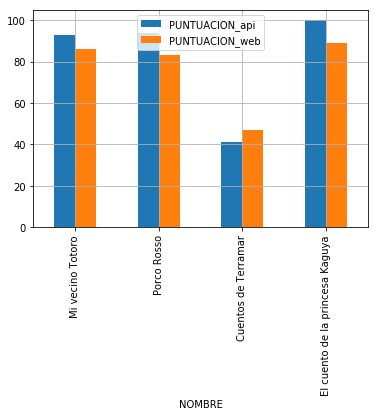

In [6]:
df_combined.plot(x='NOMBRE', y=['PUNTUACION_api', 'PUNTUACION_web'], kind="bar", grid=True)

df_combined.plot